In [95]:
import xarray as xr
import numpy as np
import xesmf as xe
import os


gridFile="/Users/james/Documents/Github/esm_lab/gridTools/nep7_grid/ocean_hgrid.nc"
#gridFile = "/Users/james/Downloads/gridFile.nc"
topoFile="/Users/james/Downloads/GEBCO_2020.nc"
gridGeoLoc = "corner"
topoVarName = 'elevation'
periodic=True
method='conservative'
gridLatName = None
gridLonName = None
topoLatName = None
topoLonName = None
topoDimX = None
topoDimY = None
coarsenInt = 2
grid = xr.open_dataset(gridFile)
gridGeoLoc = 'corner'

if gridGeoLoc == "center":
    if 'nx' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nx"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nx"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nx"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nx"})
        else:
            print ('Error: plase define gridDimX')
    if 'ny' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "ny"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "ny"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "ny"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "ny"})
        else:
            print ('Error: plase define gridDimY')
    
    if 'lat_centers' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_centers'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_centers'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_centers'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_centers'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_centers' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_centers'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_centers'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_centers'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_centers'})
        else:
            print('Error: Please define gridLonName')
    
    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_centers = grid['lon_centers'].values
    lat_centers = grid['lat_centers'].values
    
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lon_corners.shape[0] + 1, lon_corners.shape[1] + 1))
    filler_array[0:lon_corners.shape[0], 0:lon_corners.shape[1]] = lon_corners[:,:]
    extCol = np.append(np.diff(lon_corners[:,-1]), np.diff(lon_corners[:,-1])[-1])  + lon_corners[:,-1]
    extRow = np.append(np.diff(lon_corners[-1,:], axis=0), np.diff(lon_corners[-1,:], axis=0)[-1])  + lon_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lon_corners[-1,:])[-1]*2  + lon_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    # plt.pcolormesh(filler_array)
    grid['lon_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )
    
    
    # trying to expand out the cornesr here by taking the difference of the last row/column, 
    # adding the difference to the last row/column, then plugging that new row/column into an expanded matrix called filler_array
    filler_array = np.zeros((lat_corners.shape[0] + 1, lat_corners.shape[1] + 1))
    filler_array[0:lat_corners.shape[0], 0:lat_corners.shape[1]] = lat_corners[:,:]
    extCol = np.append(np.diff(lat_corners[:,-1]), np.diff(lat_corners[:,-1])[-1])  + lat_corners[:,-1]
    extRow = np.append(np.diff(lat_corners[-1,:], axis=0), np.diff(lat_corners[-1,:], axis=0)[-1])  + lat_corners[-1,:]
    filler_array[0:extCol.shape[0], -1] = extCol
    filler_array[-1, 0:extRow.shape[0]] = extRow
    # there is one final corner that's not been interpolated, fill that cell here - have to double the difference to avoid repeating 
    # the same value for that final corner
    final_corner = np.diff(lat_corners[-1,:])[-1]*2  + lat_corners[-1,-1]
    filler_array[-1,-1] = final_corner
    # testing
    #plt.pcolormesh(filler_array)
    # add formal lat corner to grid object
    grid['lat_corners'] = xr.DataArray(data=filler_array, dims=("nyp", "nxp"))
    
if gridGeoLoc == "corner":
    # organize dimensions to nx ny nxp nyp
    if 'nxp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimX : "nxp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lon" : "nxp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"longitude" : "nxp"})
        elif 'x' in grid.dims:
            grid = grid.rename_dims({"x" : "nxp"})
        else:
            print ('Error: plase define gridDimX')
    if 'nyp' not in grid.dims:
        if gridDimX != None:
            grid = grid.rename_dims({gridDimY : "nyp"})
        elif 'lon' in grid.dims:
            grid = grid.rename_dims({"lat" : "nyp"})
        elif 'longitude' in grid.dims:
            grid = grid.rename_dims({"latitude" : "nyp"})
        elif 'y' in grid.dims:
            grid = grid.rename_dims({"y" : "nyp"})
        else:
            print ('Error: plase define gridDimY')
            
    if 'lat_corners' not in grid.variables:
        if gridLatName != None:
            grid = grid.rename({gridLatName: 'lat_corners'})
        elif 'y' in grid.variables:
            grid = grid.rename({'y': 'lat_corners'})
        elif 'lat' in grid.variables:
            grid = grid.rename({'lat': 'lat_corners'})
        elif 'latitude' in grid.variables:
            grid = grid.rename({'latitude': 'lat_corners'})
        else:
            print('Error: please define gridlatname')
    
            
    if 'lon_corners' not in grid.variables:
        if gridLonName != None:
            grid = grid.rename({gridLonName : 'lon_corners'})
        elif 'x' in grid.variables:
            grid = grid.rename({'x': 'lon_corners'})
        elif 'lon' in grid.variables:
            grid = grid.rename({'lon': 'lon_corners'})
        elif 'longitude' in grid.variables:
            grid= grid.rename({'longitude': 'lon_corners'})
        else:
            print('Error: Please define gridLonName')

    # fix longitude from -180 to 180
    if "lon_corners" in grid.coords:
        grid = grid.assign_coords(lon_corners=(np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                                        grid['lon_corners'].values)))
        grid = grid.swap_dims({'lon_corners' : 'nxp'})    
    if "lon_corners" in grid.data_vars:
        grid['lon_corners'].values =  np.where(grid['lon_corners'].values > 180., grid['lon_corners'].values - 360, 
                                               grid['lon_corners'].values)

    lon_corners = grid['lon_corners'].values
    lat_corners = grid['lat_corners'].values
    
    # To use conservative regidding, we need the cells centers. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_centers = 0.25 * (
        lon_corners[:-1, :-1]
        + lon_corners[1:, :-1]
        + lon_corners[:-1, 1:]
        + lon_corners[1:, 1:]
    )
    
    lat_centers = 0.25 * (
        lat_corners[:-1, :-1]
        + lat_corners[1:, :-1]
        + lat_corners[:-1, 1:]
        + lat_corners[1:, 1:]
    )
    
    grid['lat_centers'] = xr.DataArray(data=lat_centers, dims=("ny", "nx"))
    grid['lon_centers'] = xr.DataArray(data=lon_centers, dims=("ny", "nx"))
    

    

In [96]:
# TOPOGRAPHY XARRAY OBJECT ORGANIZATION
topo = xr.open_dataset(topoFile)

if 'nx' not in topo.dims:
    if topoDimX != None:
        topo = topo.rename_dims({topoDimX : "nx"})
    elif 'lon' in topo.dims:
        topo = topo.rename_dims({"lon" : "nx"})
    elif 'longitude' in topo.dims:
        topo = topo.rename_dims({"longitude" : "nx"})
    elif 'x' in topo.dims:
        topo = topo.rename_dims({"x" : "nx"})
    else:
        print ('Error: plase define topoDimX')
if 'ny' not in topo.dims:
    if topoDimY != None:
        topo = topo.rename_dims({topoDimY : "ny"})
    elif 'lat' in topo.dims:
        topo = topo.rename_dims({"lat" : "ny"})
    elif 'latitude' in topo.dims:
        topo = topo.rename_dims({"latitude" : "ny"})
    elif 'y' in topo.dims:
        topo = topo.rename_dims({"y" : "ny"})
    else:
        print ('Error: plase define topoDimY')
        
# coarsen topo file down based on coarsenInt
topo = topo.coarsen(nx=coarsenInt,ny=coarsenInt, boundary='pad').median()

if 'lat_centers' not in topo.variables:
    if topoLatName != None:
        topo = topo.rename({topoLatName: 'lat_centers'})
    elif 'y' in topo.variables:
        topo = topo.rename({'y': 'lat_centers'})
    elif 'lat' in topo.variables:
        topo = topo.rename({'lat': 'lat_centers'})
    elif 'latitude' in topo.variables:
        topo = topo.rename({'latitude': 'lat_centers'})
    else:
        print('Error: please define gridlatname')
if 'lon_centers' not in topo.variables:
    if topoLonName != None:
        topo = topo.rename({topoLonName : 'lon_centers'})
    elif 'x' in topo.variables:
        topo = topo.rename({'x': 'lon_centers'})
    elif 'lon' in topo.variables:
        topo = topo.rename({'lon': 'lon_centers'})
    elif 'longitude' in grid.variables:
        topo = topo.rename({'longitude': 'lon_centers'})
    else:
        print('Error: Please define gridLonName')


# grab index location of grid extents
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# if longitudes are 0 to 360, convert to -180 to 180
if "lon_centers" in topo.coords:
    topo = topo.assign_coords(lon_centers=(np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, 
                                                    topo['lon_centers'].values)))
    topo = topo.swap_dims({'lon_centers' : 'nx'})
if "lon_centers" in topo.data_vars:
    topo['lon_centers'].values =  np.where(topo['lon_centers'].values > 180., topo['lon_centers'].values - 360, topo['lon_centers'].values)


In [97]:
topo2 = topo

In [98]:
topo2

<xarray.Dataset>
Dimensions:      (nx: 43200, ny: 21600)
Coordinates:
    lon_centers  (nx) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lat_centers  (ny) float64 -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
Dimensions without coordinates: nx, ny
Data variables:
    elevation    (ny, nx) float32 2.83e+03 2.83e+03 ... -4.225e+03 -4.225e+03
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

In [99]:
expLonCenters = np.zeros(len(topo2.lon_centers.values) + 2)
expLonCenters[0], expLonCenters[-1] = np.nan, np.nan
expLonCenters[1:-1] = topo2.lon_centers.values
expLonCenters[0] = expLonCenters[1] - np.diff(expLonCenters[1:3])
expLonCenters[-1] = expLonCenters[-2] + np.diff(expLonCenters[-3:-1])
expElevation = np.zeros((topo2.elevation.values.shape[0],topo2.elevation.values.shape[1] + 2 ))
expElevation[:,1:-1] = topo2.elevation.values
expElevation[:,0] = expElevation[:,-2]
expElevation[:,-1] = expElevation[:,1]


# define data with variable attributes
data_vars = {topoVarName:(['ny', 'nx'], expElevation, 
                         {'units': 'm', 
                          'long_name':'elevation'})}

# define coordinates
coords = {'lon_centers': (['nx'], expLonCenters), 'lat_centers':(['ny'], topo2.lat_centers.values)}

# define global attributes
attrs = {'author':'Jane Doe', 
         'email':'address@email.com'}

# create dataset
ds = xr.Dataset(data_vars=data_vars, 
                coords=coords, 
                attrs=attrs)

topo = ds

In [100]:
topo = ds

latMinInd = find_nearest(array = topo.lat_centers.values, value = np.min(grid.lat_centers.values))
latMaxInd = find_nearest(array = topo.lat_centers.values, value = np.max(grid.lat_centers.values))
lonMinInd = find_nearest(array = topo.lon_centers.values, value = np.min(grid.lon_centers.values))
lonMaxInd = find_nearest(array = topo.lon_centers.values, value = np.max(grid.lon_centers.values))

if lonMinInd > lonMaxInd:
    temp = lonMinInd
    lonMinInd = lonMaxInd
    lonMaxInd = temp

# slice the large topography file down to the extents of the grid file + 1 on either side because we will slice down 2 points 
# after the corner points are calculated
topo = topo.isel(nx=slice(lonMinInd - 1, lonMaxInd + 1), ny=slice(latMinInd - 1, latMaxInd + 1))

lon_centers = topo['lon_centers'].values
lat_centers = topo['lat_centers'].values

lon_corners = 0.25 * (
    lon_centers[:-1]
    + lon_centers[1:]
    + lon_centers[:-1]
    + lon_centers[1:]
)

lat_corners = 0.25 * (
    lat_centers[:-1]
    + lat_centers[1:]
    + lat_centers[:-1]
    + lat_centers[1:]
)

# trim down the centers so they are 1 less than the corner points we just calculated
topo = topo.isel(nx=slice(1,-1), ny=slice(1,-1))

# extract the topo values and add them back later with proper dimensions
elev = topo[topoVarName].values

# add nxp and nyp dimensions for the lat/lon corners to latch onto
topo = topo.expand_dims({'nyp':(len(topo.ny) + 1)})
topo = topo.expand_dims({'nxp':(len(topo.nx) + 1)})

# add the lat/lon corners as data variables
topo['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
topo['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))

# drop elevation and bring it back, this time constraining the dimensions to lat/lon centers
topo = topo.drop_vars(topoVarName)
topo[topoVarName] = (('ny', 'nx'), elev)

# make lat/lons 2 dimensions just like the grids wewe are matching to
lon2d, lat2d = np.meshgrid(topo.lon_centers.values, topo.lat_centers.values)
lon2d_b, lat2d_b = np.meshgrid(topo.lon_corners.values, topo.lat_corners.values)

# assign 2d coordinates as lat/lon 
topo = topo.assign_coords({"lon" : (("ny", "nx"), lon2d)})
topo = topo.assign_coords({"lat" : (("ny", "nx"), lat2d)})
topo = topo.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
topo = topo.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})

In [101]:
topo

<xarray.Dataset>
Dimensions:      (nx: 43189, nxp: 43190, ny: 8394, nyp: 8395)
Coordinates:
    lon_centers  (nx) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 179.9
    lat_centers  (ny) float64 10.79 10.8 10.8 10.81 ... 80.7 80.71 80.72 80.73
    lon          (ny, nx) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
    lat          (ny, nx) float64 10.79 10.79 10.79 10.79 ... 80.73 80.73 80.73
    lon_b        (nyp, nxp) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    lat_b        (nyp, nxp) float64 10.78 10.78 10.78 ... 80.73 80.73 80.73
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    lat_corners  (nyp) float64 10.78 10.79 10.8 10.81 ... 80.72 80.72 80.73
    lon_corners  (nxp) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
    elevation    (ny, nx) float64 -5.744e+03 -5.777e+03 ... -1.678e+03
Attributes:
    author:   Jane Doe
    email:    address@email.com

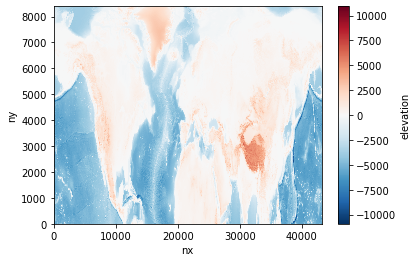

In [102]:
topo.elevation.plot()